In [20]:
# import statements
import pandas as pd
import numpy as np
from IPython.display import clear_output
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from collections import Counter
from google.colab import files
import io

In [21]:
# download nltk package
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Obtain data from github repository

In [22]:
data_url = 'https://raw.githubusercontent.com/owl0108/MAIS202-Final-Project/master/data/train.tsv'
org_df = pd.read_table(data_url)
# display
org_df.iloc[:20]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


## Reduce the imbalance of training data

In [23]:
# much more instances of sentiment = 2
# we'll reduce the number of instances with sentiment = 2 to 30000
org_df.groupby('Sentiment').count()

,PhraseId,SentenceId,Phrase
Sentiment,,,
0,7072,7072,7072
1,27273,27273,27273
2,79582,79582,79582
3,32927,32927,32927
4,9206,9206,9206


In [24]:
temp_df = org_df[org_df.Sentiment == 2].reset_index().reset_index().loc[:, ['level_0', 'index']].rename({'level_0':'2_count'}, axis=1)
temp_df

,2_count,index
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
...,...,...
79577,79577,156053
79578,79578,156054
79579,79579,156055
79580,79580,156058


In [25]:
data_df = pd.merge(org_df, temp_df, how='left', left_index=True, right_on='index').drop('index', axis=1).reset_index(drop=True).fillna(-1)
data_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,2_count
0,1,1,A series of escapades demonstrating the adage ...,1,-1.0
1,2,1,A series of escapades demonstrating the adage ...,2,0.0
2,3,1,A series,2,1.0
3,4,1,A,2,2.0
4,5,1,series,2,3.0


In [26]:
# reduce the number of instances with sent=2
# shaffle rows
data_df = data_df[data_df.loc[:, '2_count'] < 30000].sample(frac=1)

In [27]:
# 106478 rows
data_df.groupby('Sentiment').count()

,PhraseId,SentenceId,Phrase,2_count
Sentiment,,,,
0,7072,7072,7072,7072
1,27273,27273,27273,27273
2,30000,30000,30000,30000
3,32927,32927,32927,32927
4,9206,9206,9206,9206


In [28]:
data_df.drop('2_count', axis=1, inplace=True)

# List of helper functions for preprocessing

In [29]:
def clean(review):
  '''(str) -> str
  Remove punctuation, numbers
  '''
  review = review.lower() # lowercase
  review = re.sub("[^A-Za-z ]", '', review) #remove non-alphabetic characters but preserve apostrophe
  return review

In [30]:
def convert_tag(tag):
  '''(str) -> str
  Convert tags associated by nltk.pos_tag into the format which lemmatizer.lemmatize understands
  Used in lemmatize() function
  '''
  if tag.startswith('V'): string = 'v'
  elif tag.startswith('J'): string = 'a'
  elif tag.startswith('R'): string = 'r'
  else: string = 'n'
  return string

In [31]:
# tokenization and clean each token
def tokenize(review):
  '''(str) -> list
  Tokenize the given string: convert it into list of words.
  '''
  tokenized = word_tokenize(review)
  tagged = nltk.pos_tag(tokenized)
  new_tokenized = list()
  
  # clean() is applied after tokenization to split shortend words properly
  # If clean() is applied before tokenization, "I'm" becomes "Im" and will be stored as one token.
  for word in tokenized:
    new_tokenized.append(clean(word))
  return new_tokenized

In [32]:
# remove stop words
def rmv_stopwd(tokenized):
  '''(list) -> list
  From the list of words, remove the stop words provided by nltk library.
  '''
  stop_list = stopwords.words('english')
  return [word for word in tokenized if word not in stop_list]

In [33]:
def lemmatize(tokenized):
  '''(list) -> list
  Given the list of words, lemmatize each word in the list and return a new list.
  Depending on the result of lemmatization, duplicates of the same word may exist in the returned list.
  '''
  tagged = nltk.pos_tag(tokenized)
  lemmatizer = WordNetLemmatizer() 
  lmt = list()
  for word, tag in tagged:
    new_tag = convert_tag(tag)
    lemmatized = lemmatizer.lemmatize(word, pos=new_tag)
    lmt.append(lemmatized)
  return lmt

In [34]:
def get_vocab(review):
  '''(str) -> list
  Given string, the function returns the list of words appearing in the given string.
  '''
  tokenized = tokenize(review)
  tokenized = rmv_stopwd(tokenized)
  tokenized = list(filter(None, tokenized))
  tokenized = lemmatize(tokenized)

  return tokenized

In [35]:
def get_bow(review_vocab, feature_vocab):
  '''(list, list) -> np.array
  Given the list of words(=vocabulary), the function returns binary-bag-of-words.
  '''
  bow_arr = np.empty(len(feature_vocab))
  count = 0
  for word in feature_vocab:
    if word in review_vocab:
      bow_arr[count] = 1
    else:
      bow_arr[count] = 0
    count += 1
  return bow_arr

### Create model_vocab in order to create BoW expression.

Limit BoW size to 10000 to avoid crashing

In [36]:
%%time
# create vocabulary for the entire dataset and create FreqDist
processed = get_vocab(data_df.Phrase.str.cat(sep=' '))
freq = nltk.FreqDist(processed)
print('The number of words in the dataset: '+str(len(freq)))

# choose the length of BoW
freq = freq.most_common(10000)

# create model_vocab
model_vocab = list()
for word, num in freq:
  model_vocab.append(word)

The number of words in the dataset: 14308
CPU times: user 1min 10s, sys: 420 ms, total: 1min 10s
Wall time: 1min 10s


In [37]:
def get_BoW(review):
  '''(str) -> np.array
  Takes string as input and returns a BoW expression
  '''
  vocab = get_vocab(review)
  return get_bow(vocab, model_vocab).reshape(1,-1)



In [41]:
%%time
review_ser = data_df.Phrase
count = 0
# make a new array
train_BoW_arr = np.empty((len(review_ser), len(model_vocab)))
for i, review in enumerate(review_ser):
  train_BoW_arr[i, :]= get_bow(review, model_vocab).reshape(1,-1)
  clear_output()
  print(count)
  count += 1

106477
CPU times: user 9min 50s, sys: 1min, total: 10min 51s
Wall time: 12min


In [42]:
train_BoW_arr.shape

(106478, 10000)

## Saving preprocessed data (enter your path)

In [43]:
np.save('your path', train_BoW_arr)

In [44]:
data_df.to_pickle('your path')

## Import preprocessed data
(if not importing, note that bow_arr = train_BoW_arr)

In [45]:
data_df = pd.read_pickle('your path of the pickle file')

In [47]:
bow_arr = np.load('your path of the npy file')

Change data type (dataframe to numpy array)




In [48]:
sen_arr = data_df.Sentiment.explode().to_numpy()

## Create train, validation, and test datasets

In [49]:
# split dataset into 3
x_tr = bow_arr[:70000]
x_vld = bow_arr[70000:85000]
x_test = bow_arr[85000:]
y_tr = sen_arr[:70000]
y_vld = sen_arr[70000:85000]
y_test = sen_arr[85000:]

# Training Step

In [50]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import joblib

In [51]:
def check_accuracy(pred, true_val, v_max):
  print('Accuracy score: ', accuracy_score(true_val, pred))
  print('Mean squared error: ', ((true_val - pred)**2).mean())

  # confusioin matrix
  print("\nConfusion matrix: ")
  print("x_label: predicted    y_label: known")
  cm = confusion_matrix(true_val, pred)
  print("\n", cm, "\n")
  sns.heatmap(cm, cmap="Blues", vmax=v_max)

## Multinomial Naive Bayes

In [52]:
%%time
clf = MultinomialNB()
clf.fit(x_tr,y_tr)

CPU times: user 5.16 s, sys: 204 ms, total: 5.36 s
Wall time: 3.87 s


Accuracy score:  0.5478666666666666
Mean squared error:  0.8601333333333333

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 282  492  115   80   17]
 [ 266 2117  835  568   41]
 [  35  609 2562  869   49]
 [  32  514  963 2825  437]
 [   6   54   92  708  432]] 



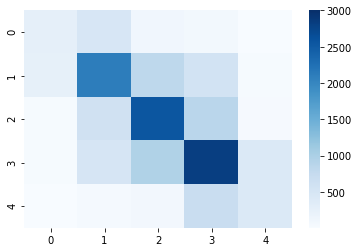

In [61]:
y_pred = clf.predict(x_vld)
check_accuracy(y_pred, y_vld, 3000)

## Output trained model and model_vacab

In [60]:
joblib.dump(model_vocab, "your path")
joblib.dump(clf, "your path")

['/content/drive/My Drive/MAIS202/Final_result_2/multi_NB.pkl']